In [5]:
import os

import numpy as np
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Embedding, Input, RepeatVector, GRU
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [0]:
import os
SOURCE_FOLDER = "drive/Colab Notebooks/"

In [7]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4012523721064357977
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11287966516
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7400453524375176930
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
#file_path = "D:\\Computer_Science_Project\\Encoder-Decoder\\new_chr_data.txt"
with open("drive/Colab Notebooks/new_chr_data.txt") as new_chr_file:
     new_chr_data_combination = [line.strip() for line in new_chr_file.readlines()]


In [0]:
#preprocess for keras
NUM_WORDS = 6000
SEQUENCE_LEN = 11

In [0]:
tokenizer = Tokenizer(num_words=NUM_WORDS, split=' ')
#tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_chr_data_combination)
seqs = tokenizer.texts_to_sequences(new_chr_data_combination)
seqs = [seqs[i] for i in range(len(seqs)) if len(seqs[i]) > 0]

In [0]:
pad_seqs = [i for i in seqs if len(i) > 0]
pad_seqs = pad_sequences(pad_seqs,
                         SEQUENCE_LEN
                        )

In [14]:
pad_seqs.shape

(5219241, 11)

In [26]:
pad_seqs[0]

array([   0,    0,    0,    0,    0,    0, 2077, 2905,  399, 2973,  468],
      dtype=int32)

In [0]:
#The model
EMBED_SIZE = 100
LATENT_SIZE = 100
batch_size = 96

In [ ]:
#====== Encoder =====#
inputs = Input(shape=(SEQUENCE_LEN,), 
               name='Encoder-Input')

emb_layer = Embedding(NUM_WORDS, 
                      EMBED_SIZE, 
                      input_length = SEQUENCE_LEN, 
                      name = 'Encoder-Embedding-Layer', 
                      mask_zero = False)

emb_out = emb_layer(inputs)

state_h = GRU(LATENT_SIZE, 
              name= 'Encoder-GRU')(emb_out)

encoded  = Model(inputs  = inputs, 
                 outputs = state_h, 
                 name    = 'Encoder-Model')

encoded_out = encoded(inputs)

In [ ]:
#===== Decoder =====#
decoded = RepeatVector(SEQUENCE_LEN)(encoded_out)

decoder_gru = GRU(LATENT_SIZE, 
                  return_sequences = True, 
                  name = 'Decoder-GRU')

decoder_output = decoder_gru(decoded)

decoder_dense = Dense(NUM_WORDS, 
                      activation='softmax', 
                      name='Decoder-Dense')

decoder_outputs = decoder_dense(decoder_output)

In [17]:
autoencoder  = Model(encoder_inputs, decoder_outputs )

checkpoint = ModelCheckpoint(os.path.join(SOURCE_FOLDER, "autoencoderGRU.h5"), save_best_only=True)

autoencoder.compile(optimizer=optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=["accuracy"])
#autoencoder.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=["accuracy"])


history = autoencoder.fit(pad_seqs, 
                            np.expand_dims(pad_seqs, -1),
                            batch_size=batch_size,
                            epochs=5,
                            validation_split=0.12,
                            callbacks=[checkpoint])

Train on 4592932 samples, validate on 626309 samples
Epoch 1/5
  59808/4592932 [..............................] - ETA: 52:40 - loss: 3.1544 - acc: 0.7318 169728/4592932 [>.............................] - ETA: 50:31 - loss: 3.0018 - acc: 0.7331 273024/4592932 [>.............................] - ETA: 49:19 - loss: 2.9708 - acc: 0.7333 369504/4592932 [=>............................] - ETA: 48:22 - loss: 2.9579 - acc: 0.7333 468288/4592932 [==>...........................] - ETA: 47:18 - loss: 2.9481 - acc: 0.7336 565632/4592932 [==>...........................] - ETA: 46:16 - loss: 2.9421 - acc: 0.7337 665472/4592932 [===>..........................] - ETA: 45:10 - loss: 2.9393 - acc: 0.7336 766560/4592932 [====>.........................] - ETA: 43:57 - loss: 2.9369 - acc: 0.7336 873888/4592932 [====>.........................] - ETA: 42:38 - loss: 2.9348 - acc: 0.7336 976608/4592932 [=====>........................] - ETA: 41:24 - loss: 2.9334 - acc: 0.73361078080/4592932 [======>.............

  27936/4592932 [..............................] - ETA: 52:18 - loss: 0.6318 - acc: 0.8622 143424/4592932 [..............................] - ETA: 49:43 - loss: 0.5904 - acc: 0.8733 253632/4592932 [>.............................] - ETA: 48:21 - loss: 0.5610 - acc: 0.8811 369408/4592932 [=>............................] - ETA: 47:12 - loss: 0.5287 - acc: 0.8895 472128/4592932 [==>...........................] - ETA: 46:10 - loss: 0.5101 - acc: 0.8953 572640/4592932 [==>...........................] - ETA: 45:08 - loss: 0.4837 - acc: 0.9018 669984/4592932 [===>..........................] - ETA: 44:08 - loss: 0.4601 - acc: 0.9075 773760/4592932 [====>.........................] - ETA: 43:02 - loss: 0.4369 - acc: 0.9130 875616/4592932 [====>.........................] - ETA: 41:57 - loss: 0.4156 - acc: 0.9179 977088/4592932 [=====>........................] - ETA: 40:50 - loss: 0.3974 - acc: 0.92211075680/4592932 [======>.......................] - ETA: 39:46 - loss: 0.3794 - acc: 0.92611178688/45

  23808/4592932 [..............................] - ETA: 53:53 - loss: 0.0153 - acc: 0.9971 120480/4592932 [..............................] - ETA: 51:43 - loss: 0.0171 - acc: 0.9968 219360/4592932 [>.............................] - ETA: 50:23 - loss: 0.0184 - acc: 0.9965 317280/4592932 [=>............................] - ETA: 49:16 - loss: 0.0192 - acc: 0.9963 416544/4592932 [=>............................] - ETA: 48:06 - loss: 0.0194 - acc: 0.9962 515808/4592932 [==>...........................] - ETA: 46:57 - loss: 0.0310 - acc: 0.9947 615264/4592932 [===>..........................] - ETA: 45:49 - loss: 0.0288 - acc: 0.9950 714336/4592932 [===>..........................] - ETA: 44:41 - loss: 0.0272 - acc: 0.9952 810816/4592932 [====>.........................] - ETA: 43:34 - loss: 0.0260 - acc: 0.9954 916992/4592932 [====>.........................] - ETA: 42:12 - loss: 0.0253 - acc: 0.99551038528/4592932 [=====>........................] - ETA: 40:43 - loss: 0.0248 - acc: 0.99551173216/45

   7584/4592932 [..............................] - ETA: 57:12 - loss: 0.0148 - acc: 0.9972 103680/4592932 [..............................] - ETA: 52:01 - loss: 0.0154 - acc: 0.9969 201312/4592932 [>.............................] - ETA: 50:49 - loss: 0.0155 - acc: 0.9969 298368/4592932 [>.............................] - ETA: 49:40 - loss: 0.0154 - acc: 0.9969 401088/4592932 [=>............................] - ETA: 48:13 - loss: 0.0224 - acc: 0.9957 512256/4592932 [==>...........................] - ETA: 46:44 - loss: 0.0202 - acc: 0.9961 615936/4592932 [===>..........................] - ETA: 45:28 - loss: 0.0188 - acc: 0.9964 721824/4592932 [===>..........................] - ETA: 44:12 - loss: 0.0181 - acc: 0.9965 834048/4592932 [====>.........................] - ETA: 42:52 - loss: 0.0175 - acc: 0.9966 937824/4592932 [=====>........................] - ETA: 41:40 - loss: 0.0172 - acc: 0.99671047936/4592932 [=====>........................] - ETA: 40:22 - loss: 0.0239 - acc: 0.99561149024/45

#### Save the completed model and the encoded model

In [0]:
autoencoder.save(os.path.join(SOURCE_FOLDER, "seq2seq_Model_GRU_5epochs_6000words_adam.h5"))

In [0]:
encoded.save(os.path.join(SOURCE_FOLDER,"encoder_model_GRU_5epochs_6000words_adam.h5"))

In [0]:
# save the tokenizer too

In [0]:
import pickle
with open(os.path.join(SOURCE_FOLDER, "tokenizer.pk"), "wb") as handle:
    pickle.dump(tokenizer, handle)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

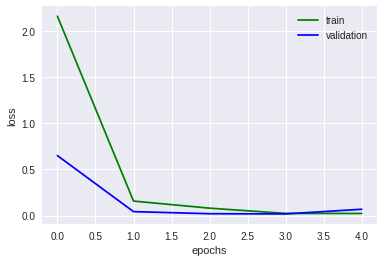

In [23]:
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(loc="best")
plt.show()